In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

In [3]:
df = pd.read_csv("data/data_merge.csv")

In [4]:
num_columns = [col for col in df.columns if df[col].dtype != "object"]
cat_columns = [col for col in df.columns if df[col].dtype == "object"]

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

std = StandardScaler()
ohe= OneHotEncoder(sparse_output=False)

log_1p = FunctionTransformer(func=np.log1p)
preprocessor_pca = ColumnTransformer(
    transformers=[
        ("ohe",ohe,cat_columns),
        ("log",log_1p,num_columns)
    ]
    
)
tsne=Pipeline([
     ('preprocessor', preprocessor_pca),
     ('std', std ),
     ("tsne", TSNE(n_components=2,random_state=42,verbose=2,n_jobs=-1))
])

tsne_value = tsne.fit_transform(df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 92901 samples in 0.002s...
[t-SNE] Computed neighbors for 92901 samples in 14.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 92901
[t-SNE] Computed conditional probabilities for sample 2000 / 92901
[t-SNE] Computed conditional probabilities for sample 3000 / 92901
[t-SNE] Computed conditional probabilities for sample 4000 / 92901
[t-SNE] Computed conditional probabilities for sample 5000 / 92901
[t-SNE] Computed conditional probabilities for sample 6000 / 92901
[t-SNE] Computed conditional probabilities for sample 7000 / 92901
[t-SNE] Computed conditional probabilities for sample 8000 / 92901
[t-SNE] Computed conditional probabilities for sample 9000 / 92901
[t-SNE] Computed conditional probabilities for sample 10000 / 92901
[t-SNE] Computed conditional probabilities for sample 11000 / 92901
[t-SNE] Computed conditional probabilities for sample 12000 / 92901
[t-SNE] Computed conditional probabilities for sa

In [6]:
# import pickle
# pickle_out = open("tsne_com2.pkl", "wb") 
# pickle.dump(tsne_value, pickle_out) 
# pickle_out.close()
# pickle_in = open('tsne.pkl', 'rb') 
# tsne_value = pickle.load(pickle_in)

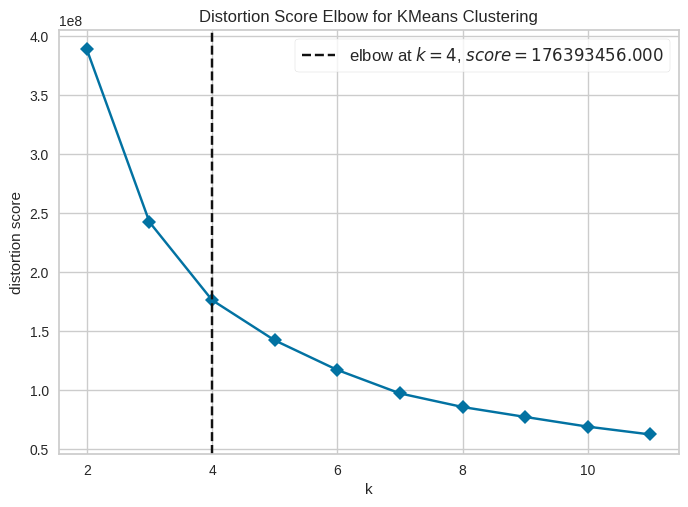

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(n_init=10,random_state=42),metric="distortion", k=(2,12),timings=False)

visualizer.fit(tsne_value)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [8]:
kmeans = KMeans(n_clusters=4,n_init=10,random_state=42)
kmeans.fit(tsne_value)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [9]:
df["label"]=kmeans.labels_

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2', 7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}


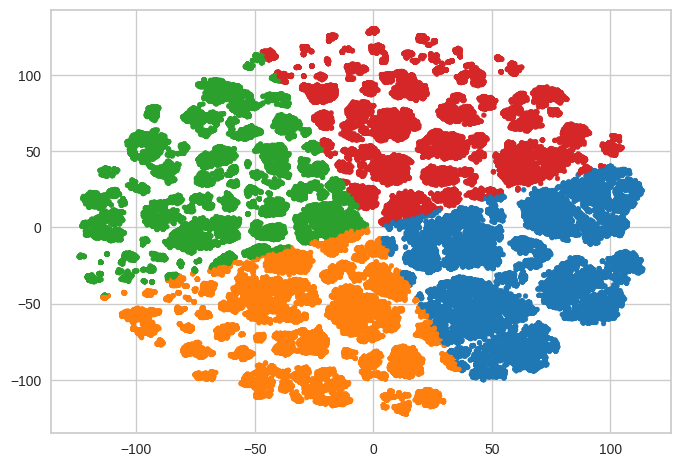

In [10]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.colors as mcolors


# Créer une liste de couleurs à partir de la palette "Set1" de Matplotlib
set1_colors = list(mcolors.TABLEAU_COLORS.values())[:10]

# Créer un dictionnaire pour mapper des couleurs aux valeurs de la liste
color_dict = {i: set1_colors[i] for i in range(len(set1_colors))}
print(color_dict)

plt.scatter(tsne_value[:,0],tsne_value[:,1],marker=".",c=[color_dict[i] for i in df["label"]])
plt.show()

In [11]:
result = df.groupby(['label']).mean()
result

/tmp/ipykernel_20853/825856455.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result = df.groupby(['label']).mean()


,nb_items_total,montant_total,nb_commande,mean_review_score,mean_payment_installments,mean_length_comment_title,mean_length_comment_message,mean_distance,recence,med_product_photos_qty,med_product_description_lenght
label,,,,,,,,,,,
0,1.059742,169.636453,1.000000,4.315386,3.694940,0.088220,14.572792,5.621002,306.575579,2.186970,786.037001
1,1.100338,137.494937,1.002196,4.195070,2.685527,0.870417,23.382712,5.457086,305.705660,2.331511,674.655294
2,1.183259,152.447586,1.005988,4.068601,1.488471,1.700791,28.375317,5.628455,284.320814,2.213289,871.243670
3,1.384582,200.581978,1.126499,3.912504,3.720937,2.853318,43.045719,5.641723,273.551408,2.146489,803.771728


In [12]:
import plotly.graph_objects as go

categories = result.columns
fig = go.Figure()

for g in result.index:
    fig.add_trace(go.Scatterpolar(
        r = result.loc[g].values,
        theta = categories,
        fill = 'toself',
        name = f'cluster #{g}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5] # here we can define the range
    )),
  showlegend=True,
    title="Issues with Plotly",
    title_x=0.5
)

fig.show()

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline


std = StandardScaler()

log_1p = FunctionTransformer(func=np.log1p)
preprocessor_pca = ColumnTransformer(
    transformers=[
        ("log",log_1p,num_columns)
    ]
    
)
pipe=Pipeline([
     ('preprocessor', preprocessor_pca),
     ('std', std )
])



In [20]:
from kmodes.kprototypes import KPrototypes
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

model_Kproto = KPrototypes(n_clusters=4, init="Cao", verbose=2, n_jobs=-1, n_init=8, random_state=42)
df_std = df.copy()
df_std[num_columns] = pipe.fit_transform(df[num_columns])
model_Kproto.fit_predict(df_std, categorical = catColumnsPos)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 6, iteration: 1/100, moves: 31393, ncost: 946734.8342586237
Run: 5, iteration: 1/100, moves: 29872, ncost: 917574.9537613371
Run: 2, iteration: 1/100, moves: 20939, ncost: 891620.3279055256
Run: 8, iteration: 1/100, moves: 25733, ncost: 898059.3993874758
Run: 1, iteration: 1/100

array([1, 2, 2, ..., 0, 1, 2], dtype=uint16)

In [21]:
# Add the cluster to the dataframe
df_kproto= df.copy()
df_kproto['label'] = model_Kproto.labels_

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2', 7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}


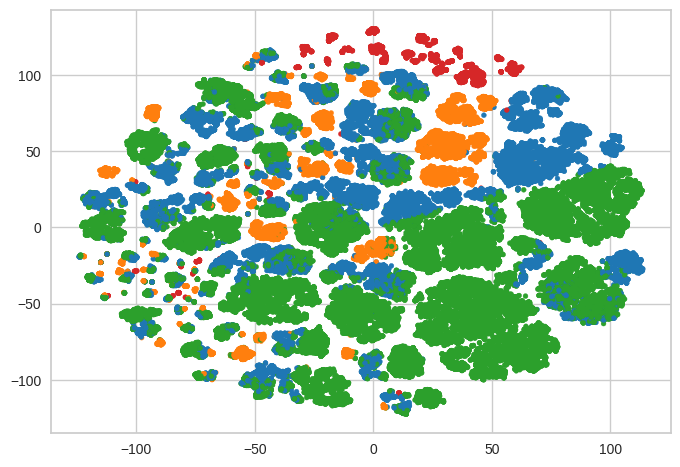

In [22]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.colors as mcolors


# Créer une liste de couleurs à partir de la palette "Set1" de Matplotlib
set1_colors = list(mcolors.TABLEAU_COLORS.values())[:10]

# Créer un dictionnaire pour mapper des couleurs aux valeurs de la liste
color_dict = {i: set1_colors[i] for i in range(len(set1_colors))}
print(color_dict)

plt.scatter(tsne_value[:,0],tsne_value[:,1],marker=".",c=[color_dict[i] for i in df_kproto["label"]])
plt.show()

In [23]:
result_kprot = df.groupby(['label']).mean()
result_kprot

/tmp/ipykernel_20853/3786504865.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,nb_items_total,montant_total,nb_commande,mean_review_score,mean_payment_installments,mean_length_comment_title,mean_length_comment_message,mean_distance,recence,med_product_photos_qty,med_product_description_lenght
label,,,,,,,,,,,
0,1.059742,169.636453,1.000000,4.315386,3.694940,0.088220,14.572792,5.621002,306.575579,2.186970,786.037001
1,1.100338,137.494937,1.002196,4.195070,2.685527,0.870417,23.382712,5.457086,305.705660,2.331511,674.655294
2,1.183259,152.447586,1.005988,4.068601,1.488471,1.700791,28.375317,5.628455,284.320814,2.213289,871.243670
3,1.384582,200.581978,1.126499,3.912504,3.720937,2.853318,43.045719,5.641723,273.551408,2.146489,803.771728


In [24]:
import plotly.graph_objects as go

categories = result_kprot.columns
fig = go.Figure()

for g in result_kprot.index:
    fig.add_trace(go.Scatterpolar(
        r = result_kprot.loc[g].values,
        theta = categories,
        fill = 'toself',
        name = f'cluster #{g}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5] # here we can define the range
    )),
  showlegend=True,
    title="Issues with Plotly",
    title_x=0.5
)

fig.show()

In [26]:

df.to_csv("data/df_tsne_comp2_kmean.csv",index=False)
df_kproto.to_csv("data/df_tsne_comp2_kproto.csv",index=False)